In this notebook, I will train and test only the Predicate Disambiguation part of the SRL model on the noUniteD-SRL dataset generated. This task is composed of multiple steps:
<ol>
<li> Train the PD model on the verbal predicates + unambiguous nominal predicates
<li> Generate a dataset of phrases with nominal ambiguous synsets with corresponding predicate identifications outputs (so that the model understands which words in the sentence to classify)
<li> check the results proposed and compare it with the classical model implemented on notebook 1)
</ol>

## Prerequisites

In [1]:
import os, sys

import numpy as np
import tqdm
import torch

/home/marco/miniconda3/envs/nuans_minihw2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Important paths for the notebook:

In [2]:
datasets_root_path = './temp_files/'
srl_dataset_path = os.path.join(datasets_root_path, 'maven_nounited_srl')
checkpoints_dir_path = './checkpoints/'
model_dir_path = os.path.join(checkpoints_dir_path, 'models_nounited_maven')

srl_dataset_dict_paths = {}
for lang in os.listdir(srl_dataset_path):
    dataset_lang_path = os.path.join(srl_dataset_path, lang)
    if os.path.isdir(dataset_lang_path):
        srl_dataset_dict_paths[lang] = {}
        for d_type in os.listdir(dataset_lang_path):
            d_name = d_type.split('.')[0]
            srl_dataset_dict_paths[lang][d_name] = os.path.join(dataset_lang_path, d_type)

In [3]:
%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [4]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
global_params = {
    'batch_size': 32,
    'transformer_name': "xlm-roberta-base",
}

In [6]:
from code_files.datasets.dataset_nounited import DatasetNoUniteD

## 1. Training the Predicate Disambiguation-only model in order to classify ambiguous nominal synsets

In [7]:
split_type = ''

In [8]:
dataset_train_en_pid = DatasetNoUniteD(  srl_dataset_dict_paths['EN']['train'], split_predicates=False, split_type_to_use = split_type )
dataset_dev_en_pid = DatasetNoUniteD(  srl_dataset_dict_paths['EN']['dev'], split_predicates=False, split_type_to_use = split_type )

In [9]:
global_params.update({
    'n_roles_labels': len(dataset_train_en_pid.id_to_roles),
    'n_predicates_labels': len(dataset_train_en_pid.id_to_predicates),

    'id_to_roles': dataset_train_en_pid.id_to_roles,
    'roles_to_id': dataset_train_en_pid.roles_to_id,
    'roles_pad_id': dataset_train_en_pid.roles_pad_id,
    'roles_pad': dataset_train_en_pid.roles_pad,

    'id_to_predicates': dataset_train_en_pid.id_to_predicates,
    'predicates_to_id': dataset_train_en_pid.predicates_to_id,
    'predicates_pad_id': dataset_train_en_pid.predicates_pad_id,
    'predicates_pad': dataset_train_en_pid.predicates_pad,
})

In [10]:
np.save(os.path.join(model_dir_path, 'global_params.npy'), global_params)

In [11]:
len(dataset_train_en_pid.data), len(dataset_dev_en_pid.data)

(24575, 6143)

In [12]:
print(dataset_train_en_pid[0],'\n\n',dataset_dev_en_pid[0])

{'words': ['The', '2006', 'Pangandaran', 'earthquake', 'and', 'tsunami', 'occurred', 'on', 'July', '17', 'at', 'along', 'a', 'subduction', 'zone', 'off', 'the', 'coast', 'of', 'west', 'and', 'central', 'Java', ',', 'a', 'large', 'and', 'densely', 'populated', 'island', 'in', 'the', 'Indonesian', 'archipelago', '.'], 'predicates': ['_', '_', '_', 'MOVE-ONESELF', '_', '_', 'HAPPEN_OCCUR', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'predicates_v': ['_', '_', '_', '_', '_', '_', 'HAPPEN_OCCUR', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'predicates_n': ['_', '_', '_', 'MOVE-ONESELF', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'roles': {'6': ['_', '_', '_', 'theme', '_', '_', '_', '_', '

In [10]:
from torch.utils.data import DataLoader

dataloader_train_en_pid = DataLoader(
    dataset_train_en_pid,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_en_pid.create_collate_fn(),
    shuffle=True,
)

dataloader_dev_en_pid = DataLoader(
    dataset_dev_en_pid,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_en_pid.create_collate_fn(),
    shuffle=False,
)

In [11]:
for e in dataloader_dev_en_pid:
    ex_in = e
    break

In [12]:
smpl = 1
print(
    ex_in['words'][smpl], '\n', 
    ex_in['predicates'][smpl], '\n', 
    ex_in['predicates_positions'][smpl])

['Since', '1916', 'the', 'anniversary', 'of', 'the', 'landings', 'on', '25', 'April', 'has', 'been', 'commemorated', 'as', 'Anzac', 'Day', ',', 'becoming', 'one', 'of', 'the', 'most', 'important', 'national', 'celebrations', 'in', 'Australia', 'and', 'New', 'Zealand', '.'] 
 ['_', '_', '_', '_', '_', '_', 'LAND_GET-OFF', '_', '_', '_', '_', '_', 'CELEBRATE_PARTY', '_', '_', '_', '_', 'CHANGE_SWITCH', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'] 
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
loss_function_pid = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en_pid.predicates_pad_id) # !

In [10]:
from code_files.models.model_pid import ModelPID
from code_files.utils.utils_functions import print_summary
import torch.optim as optim

In [17]:
model_pid = ModelPID(
    loss_fn = loss_function_pid,
    hparams = global_params,
    fine_tune_transformer = True,
    has_predicates_positions = True # it does ONLY pred disamb
)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
optimizer_pid = optim.SGD(model_pid.parameters(), lr=0.0016, momentum=0.9) 

In [20]:
print_summary(model_pid, short=True)

parameters: 278,376,625
trainable parameters: 278,376,625
non-trainable parameters: 0


In [21]:
history = {}

In [22]:
from code_files.utils.Trainer_pid import Trainer_pid

trainer_pid = Trainer_pid()

history = trainer_pid.train(
    model_pid, optimizer_pid, dataloader_train_en_pid, dataloader_dev_en_pid,
    epochs=100, device=device,
    save_best=True, 
    min_score=0.8,
    save_path_name=os.path.join(model_dir_path, f'pdonly_transformer_nounited{split_type}.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 2.471862
# Validation loss => 0.689416 | f1-score: pred_iden = 0.985181 pred_dis = 0.196394 #
Epoch   1 => avg_loss: 0.557080
# Validation loss => 0.353147 | f1-score: pred_iden = 0.989409 pred_dis = 0.546970 #
Epoch   2 => avg_loss: 0.364580
# Validation loss => 0.234552 | f1-score: pred_iden = 0.988775 pred_dis = 0.690204 #
Epoch   3 => avg_loss: 0.272642
# Validation loss => 0.173927 | f1-score: pred_iden = 0.995390 pred_dis = 0.760356 #
Epoch   4 => avg_loss: 0.218716
# Validation loss => 0.138823 | f1-score: pred_iden = 0.997420 pred_dis = 0.797861 #
Epoch   5 => avg_loss: 0.183669
# Validation loss => 0.115979 | f1-score: pred_iden = 0.998230 pred_dis = 0.820449 #
----- Best value obtained, saving model -----
Epoch   6 => avg_loss: 0.158211
# Validation loss => 0.100076 | f1-score: pred_iden = 0.998167 pred_dis = 0.844168 #
----- Best value obtained, saving model -----
Epoch   7 => avg_loss: 0.139642
# Validation loss => 0.088997 | f1-score: pred_iden = 0.9

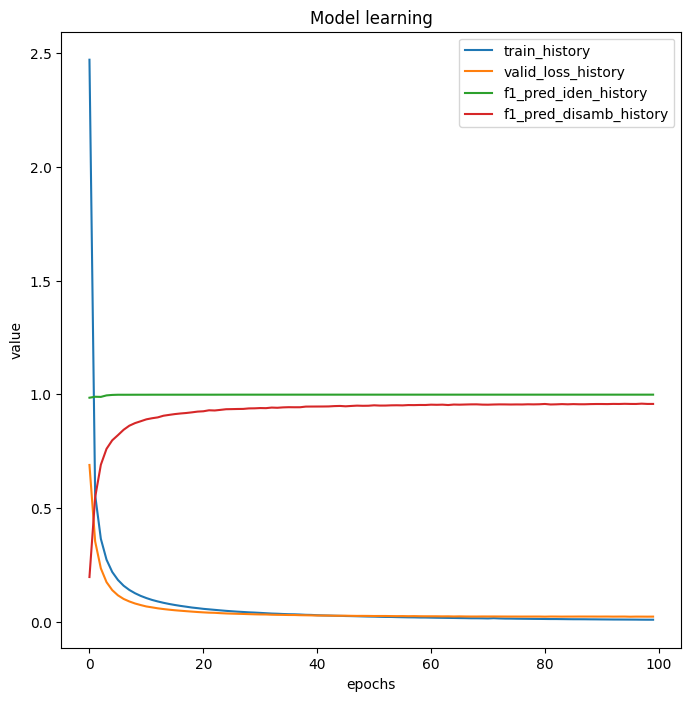

In [23]:
trainer_pid.display_history(history)

In [24]:
smpl = 1
print(
    ex_in['words'][smpl], '\n', 
    ex_in['predicates'][smpl], '\n', 
    ex_in['predicates_positions'][smpl])

['Since', '1916', 'the', 'anniversary', 'of', 'the', 'landings', 'on', '25', 'April', 'has', 'been', 'commemorated', 'as', 'Anzac', 'Day', ',', 'becoming', 'one', 'of', 'the', 'most', 'important', 'national', 'celebrations', 'in', 'Australia', 'and', 'New', 'Zealand', '.'] 
 ['_', '_', '_', '_', '_', '_', 'LAND_GET-OFF', '_', '_', '_', '_', '_', 'CELEBRATE_PARTY', '_', '_', '_', '_', 'CHANGE_SWITCH', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'] 
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [25]:
print(
    model_pid.predict(
        [ex_in['words'][smpl]],
        predicates_positions = [ex_in['predicates_positions'][smpl]]
    )[0]
)

['_', '_', '_', '_', '_', '_', 'LAND_GET-OFF', '_', '_', '_', '_', '_', 'CELEBRATE_PARTY', '_', '_', '_', '_', 'CHANGE_SWITCH', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']


## 2. Loading the best model and the SynsetExplorer's results in order to generate the dataset

getting the nominal synsets with hypernyms that were explored via SynsetExplorer

In [11]:
import json

va_frame_info = {}
with open('./va_resources/VerbAtlas-1.1.0/VerbAtlas-1.1.0/VA_frame_info.tsv') as file:
    for line in file:
        l = line.strip('\n').split('\t')
        if len(l) > 2: # l[0] = va, l[1] = name, l[2] = info
            va_frame_info[l[1].upper()] = l[2]

explored_nominal_graph_path = './va_resources/explored_nominal_graph.json'
with open(explored_nominal_graph_path, 'r') as json_file:
    explored_nominal_graph = json.load(json_file)

poss_cand_solved_statistically_path = './va_resources/poss_cand_solved_statistically.json'
with open(poss_cand_solved_statistically_path, 'r') as json_file:
    poss_cand_solved_statistically = json.load(json_file)

getting only the ones directly connected with a verbal synset of VerbAtlas

In [12]:
explored_nominal_graph_drf = {k:v for k,v in explored_nominal_graph.items() if v['is_drf'] == True}

getting only the ambiguous ones:

In [13]:
explored_nominal_graph_drf_ambiguous = {k:v for k,v in explored_nominal_graph_drf.items() if len(v['frames']) > 1}

Now, the pipeline is:
<ol>
<li> use these nominal ambiguous synsets with the function create_nounited_dataset() and the Maven dataset in order to extrapolate phrases for each synset
<li> for each synset, give the phrases to the PD model and return the frames: the most voted one is the chosen frame for that synset!
</ol>

In [14]:
datasets_path = './datasets/'

# where the dataset will be downloaded
maven_dataset_path = os.path.join(datasets_path, 'maven/')
maven_train_path = os.path.join(maven_dataset_path, "train.jsonl")
maven_valid_path = os.path.join(maven_dataset_path, "valid.jsonl")
maven_test_path = os.path.join(maven_dataset_path, "test.jsonl")

# generating the list of sentences from maven:

with open(maven_train_path, 'r') as json_file:
    maven_train = list([json.loads(json_line) for json_line in json_file])

with open(maven_valid_path, 'r') as json_file:
    maven_valid = list([json.loads(json_line) for json_line in json_file])

with open(maven_test_path, 'r') as json_file:
    maven_test = list([json.loads(json_line) for json_line in json_file])

intermediate_dataset = []
for maven_dataset_split in [maven_train, maven_valid, maven_test]:
    for el in maven_dataset_split:
        for i, sentence_tokens in enumerate(el['content']):
            intermediate_dataset.append(sentence_tokens['sentence'])

print(len(intermediate_dataset))
intermediate_dataset[:6]

49873


['The 2006 Pangandaran earthquake and tsunami occurred on July 17 at along a subduction zone off the coast of west and central Java, a large and densely populated island in the Indonesian archipelago.',
 'The shock had a moment magnitude of 7.7 and a maximum perceived intensity of IV ("Light") in Jakarta, the capital and largest city of Indonesia.',
 "There were no direct effects of the earthquake's shaking due to its low intensity, and the large loss of life from the event was due to the resulting tsunami, which inundated a portion of the Java coast that had been unaffected by the earlier 2004 Indian Ocean earthquake and tsunami that was off the coast of Sumatra.",
 'The July 2006 earthquake was also centered in the Indian Ocean, from the coast of Java, and had a duration of more than three minutes.',
 'An abnormally slow rupture at the Sunda Trench and a tsunami that was unusually strong relative to the size of the earthquake were both factors that led to it being categorized as a ts

In [15]:
import os, sys
from code_files.utils.nounited_creator import amuse_request, invero_request, create_nounited_dataset, save_nounited_dataset

# parameters:
unambiguous_candidates_path = explored_nominal_graph_drf_ambiguous # path to the (here) ambiguous candidates to be used to create the nominal part
chunk_size = 16 # number of sentences to query amuse and invero
window_span_error = 3 # the displacement between invero and amuse tokenization indices. The greater, the less are the incorrelations errors
lang = "EN"
amuse_url = 'http://127.0.0.1:3002/api/model' # put here your endpoint for AMuSE-WSD!
invero_url = 'http://127.0.0.1:3003/api/model' # put here your endpoint for invero-xl!

ambiguous_noUniteD_srl_result, ambiguous_syn_phrases_id = create_nounited_dataset(
    sentences_list = intermediate_dataset,
    unambiguous_candidates_path = unambiguous_candidates_path,
    amuse_url = amuse_url, invero_url = invero_url,
    chunk_size = chunk_size, window_span_error = window_span_error, lang = lang
)

2023-01-19 15:49:22 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-01-19 15:49:23 WARNING: Can not find mwt: default from official model list. Ignoring it.
2023-01-19 15:49:24 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2023-01-19 15:49:24 INFO: Use device: gpu
2023-01-19 15:49:24 INFO: Loading: tokenize
2023-01-19 15:49:24 INFO: Loading: pos
2023-01-19 15:49:27 INFO: Loading: lemma
2023-01-19 15:49:27 INFO: Loading: depparse
2023-01-19 15:49:27 INFO: Done loading processors!
Nominal found: 19610, Verbal found: 151363, Incorrelations: 2285, Chunk errors: 58, Sentences: 46792: 100%|██████████| 3118/3118 [1:07:12<00:00,  1.29s/it]


In [16]:
with open(os.path.join('temp_files','ambiguous_nounited.json'), 'w') as fout:
    json.dump(ambiguous_noUniteD_srl_result, fout, indent=4)

with open(os.path.join('temp_files','ambiguous_syn_phrases_id.json'), 'w') as fout:
    json.dump(ambiguous_syn_phrases_id, fout, indent=4)

Loading the resulting output

In [15]:
with open(os.path.join('temp_files','ambiguous_nounited.json'), 'r') as json_file:
    ambiguous_noUniteD_srl_result = json.load(json_file)

with open(os.path.join('temp_files','ambiguous_syn_phrases_id.json'), 'r') as json_file:
    ambiguous_syn_phrases_id = json.load(json_file)

In [16]:
ambiguous_syn_phrases_id_nominal = {k:v for k,v in ambiguous_syn_phrases_id.items() if k.split('.')[1] == 'n'}
len(ambiguous_syn_phrases_id_nominal), len(explored_nominal_graph_drf_ambiguous)

(559, 1075)

In [40]:
model_pid = ModelPID(
    hparams = global_params,
    has_predicates_positions = True # it does ONLY pred disamb
)
model_pid.load_weights(os.path.join(model_dir_path, f'pdonly_transformer_nounited{split_type}.pth'))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Solving ambiguity

In [41]:
from copy import deepcopy
from collections import Counter
from tqdm import tqdm

solved_synsets = 0
correspondence = 0
not_in_possible_frames = 0
resolved_output = {}

pbar = tqdm(ambiguous_syn_phrases_id_nominal.items(), disable=False)
pbar_desc = lambda: f"Synsets solved: {solved_synsets}, Correspondences: {correspondence}, Not in possible frames: {not_in_possible_frames}"
pbar.set_description(pbar_desc())

for syn_name, phrases_positions_pairs in pbar:
    possible_connected_frames = [f.upper() for f in explored_nominal_graph_drf_ambiguous[syn_name]['frames']]
    statistically_solved_frame = poss_cand_solved_statistically[syn_name]['frames'][0]
    np.random.shuffle(phrases_positions_pairs)

    counter_predictions = Counter()
    for (phrase_id, predicate_target_position) in phrases_positions_pairs[:10]:
        words =  ambiguous_noUniteD_srl_result[phrase_id]['words']
        predicates =  ambiguous_noUniteD_srl_result[phrase_id]['predicates']
        predicates_positions = [1 if p != '_' else 0 for p in predicates]
        prediction = model_pid.predict([words], predicates_positions = [predicates_positions])[0][predicate_target_position]
        counter_predictions[prediction] += 1

    final_prediction = counter_predictions.most_common(1)[0][0]

    resolved_output[syn_name] = {'possible_frames':possible_connected_frames, 'statistical_frame':statistically_solved_frame, 'predicted_frame':final_prediction}
    
    if statistically_solved_frame.upper() == final_prediction.upper(): 
        correspondence += 1
    if final_prediction.upper() not in possible_connected_frames:
        not_in_possible_frames += 1
    solved_synsets += 1
    pbar.set_description(pbar_desc())

Synsets solved: 559, Correspondences: 183, Not in possible frames: 246: 100%|██████████| 559/559 [01:19<00:00,  6.99it/s]


In [43]:
print(len(set([k for k,v in resolved_output.items() if v['predicted_frame'] == '_'])))
for k,v in resolved_output.items():
    if v['predicted_frame'] != '_' and (v['predicted_frame'] in v['possible_frames']):
        print('###############', k, explored_nominal_graph_drf_ambiguous[k]['definition'], '###############')
        print('connected frames:',v['possible_frames'])
        print('statistical solution:',v['statistical_frame'], va_frame_info[v['statistical_frame']])
        print('predicted:',v['predicted_frame'], va_frame_info[v['predicted_frame']])
        print('in-possibilities:',v['predicted_frame'] in v['possible_frames'])

2
############### consequence.n.01 a phenomenon that follows and is caused by some previous phenomenon ###############
connected frames: ['CAUSE-SMT', 'CREATE_MATERIALIZE', 'RESULT_CONSEQUENCE']
statistical solution: RESULT_CONSEQUENCE An agent with a co-agent makes a theme RESULT-HAVE AS CONSEQUENCE a goal using an instrument
predicted: RESULT_CONSEQUENCE An agent with a co-agent makes a theme RESULT-HAVE AS CONSEQUENCE a goal using an instrument
in-possibilities: True
############### death.n.01 the event of dying or departure from life ###############
connected frames: ['HURT_HARM_ACHE', 'KILL']
statistical solution: HURT_HARM_ACHE An agent HURTS-HARMS-ACHES an experiencer using an instrument to achieve a goal
predicted: KILL An agent KILLS a patient with an instrument in a location (+attribute)
in-possibilities: True
############### damage.n.01 the occurrence of a change for the worse ###############
connected frames: ['HURT_HARM_ACHE', 'BREAK_DETERIORATE']
statistical solution: HUR

In [42]:
for k,v in resolved_output.items():
    if v['predicted_frame'] != '_' and not (v['predicted_frame'] in v['possible_frames']):
        print('###############', k, explored_nominal_graph_drf_ambiguous[k]['definition'], '###############')
        print('connected frames:',v['possible_frames'])
        print('statistical solution:',v['statistical_frame'], va_frame_info[v['statistical_frame']])
        print('predicted:',v['predicted_frame'], va_frame_info[v['predicted_frame']])
        print('in-possibilities:',v['predicted_frame'] in v['possible_frames'])

############### rush.n.02 a sudden forceful flow ###############
connected frames: ['RAISE', 'GO-FORWARD']
statistical solution: GO-FORWARD A cause makes an agent GO FORWARD from a source to a destination  for an extent using an instrument on a location to achieve a goal
predicted: INCREASE_ENLARGE_MULTIPLY An agent INCREASES-ENLARGES-MULTIPLIES the attribute of a patient of an extent from a source to a destination using an instrument on a location in favour of a beneficiary
in-possibilities: False
############### fire.n.02 the act of firing weapons or artillery at an enemy ###############
connected frames: ['OPERATE', 'SHOOT_LAUNCH_PROPEL']
statistical solution: SHOOT_LAUNCH_PROPEL An agent SHOOTS-LAUNCHES-PROPELS a theme to a destination
predicted: DESTROY An agent DESTROYS a patient with an instrument having a result
in-possibilities: False
############### brush.n.06 a minor short-term fight ###############
connected frames: ['FIGHT', 'FACE_CHALLENGE']
statistical solution: FIGHT An

In [41]:
example_ambiguous = 'brush.n.06'
possible_connected_frames = [f.upper() for f in explored_nominal_graph_drf_ambiguous[example_ambiguous]['frames']]
statistically_solved_frame = poss_cand_solved_statistically[example_ambiguous]['frames'][0]

print('###############', example_ambiguous, explored_nominal_graph_drf_ambiguous[example_ambiguous]['definition'], '###############')

for (phrase_id, predicate_target_position) in ambiguous_syn_phrases_id_nominal[example_ambiguous][:10]:
    words =  ambiguous_noUniteD_srl_result[phrase_id]['words']
    predicates =  ambiguous_noUniteD_srl_result[phrase_id]['predicates']
    predicates_positions = [1 if p != '_' else 0 for p in predicates]
    prediction = model_pid.predict([words], predicates_positions = [predicates_positions])[0][predicate_target_position]
    print('------------------------ phrase -----------------------')
    print(' '.join([w if predicate_target_position != i else '['+w+']' for i,w in enumerate(words)]))
    print('possible frames:',possible_connected_frames)
    print('statistically solved frame:',statistically_solved_frame,'|', va_frame_info[statistically_solved_frame])
    print('prediction solved frame:',prediction,'|', va_frame_info[prediction])

############### brush.n.06 a minor short-term fight ###############
------------------------ phrase -----------------------
The events of the day started early in the morning when [skirmishes] broke out in a bar , which led to an Arsenal fan being stabbed .
possible frames: ['FIGHT', 'FACE_CHALLENGE']
statistically solved frame: FIGHT | An agent FIGHTS against a co-agent on a topic
prediction solved frame: ATTACK_BOMB | An agent ATTACKS-BOMBS a patient due to a topic using an instrument (+attribute)
------------------------ phrase -----------------------
Jamaat followers protested and there were violent [clashes] with police .
possible frames: ['FIGHT', 'FACE_CHALLENGE']
statistically solved frame: FIGHT | An agent FIGHTS against a co-agent on a topic
prediction solved frame: QUARREL_POLEMICIZE | An agent QUARRELS-POLEMICIZES with a co-agent over a theme
------------------------ phrase -----------------------
Their run included a 2–0 defeat against Peterborough United in their area fin

## Solving ambiguity both statistically and with pd model

In [19]:
from copy import deepcopy
from collections import Counter
from tqdm import tqdm

solved_synsets = 0
correspondence = 0
not_in_possible_frames = 0
resolved_output = {}

pbar = tqdm(ambiguous_syn_phrases_id_nominal.items(), disable=False)
pbar_desc = lambda: f"Synsets solved: {solved_synsets}, Correspondences: {correspondence}, Not in possible frames: {not_in_possible_frames}"
pbar.set_description(pbar_desc())

for syn_name, phrases_positions_pairs in pbar:
    possible_connected_frames = [f.upper() for f in explored_nominal_graph_drf_ambiguous[syn_name]['frames']]
    statistically_solved_frame = poss_cand_solved_statistically[syn_name]['frames'][0]
    np.random.shuffle(phrases_positions_pairs)

    counter_predictions = Counter()
    counter_predictions_in_frame = Counter()
    for (phrase_id, predicate_target_position) in phrases_positions_pairs[:10]:
        words =  ambiguous_noUniteD_srl_result[phrase_id]['words']
        predicates =  ambiguous_noUniteD_srl_result[phrase_id]['predicates']
        predicates_positions = [1 if p != '_' else 0 for p in predicates]
        prediction = model_pid.predict([words], predicates_positions = [predicates_positions])[0][predicate_target_position]
        counter_predictions[prediction] += 1
        if prediction.upper() in possible_connected_frames:
            counter_predictions_in_frame[prediction] += 1

    if len(counter_predictions_in_frame) > 0:
        final_prediction = counter_predictions_in_frame.most_common(1)[0][0]
    else:
        final_prediction = counter_predictions.most_common(1)[0][0]

    resolved_output[syn_name] = {'possible_frames':possible_connected_frames, 'statistical_frame':statistically_solved_frame, 'predicted_frame':final_prediction}
    
    if statistically_solved_frame.upper() == final_prediction.upper(): 
        correspondence += 1
    if final_prediction.upper() not in possible_connected_frames:
        not_in_possible_frames += 1
    solved_synsets += 1
    pbar.set_description(pbar_desc())

Synsets solved: 559, Correspondences: 226, Not in possible frames: 180: 100%|██████████| 559/559 [01:19<00:00,  7.01it/s]


In [20]:
print(len(set([k for k,v in resolved_output.items() if v['predicted_frame'] == '_'])))
for k,v in resolved_output.items():
    if v['predicted_frame'] != '_':
        print('###############', k, explored_nominal_graph_drf_ambiguous[k]['definition'], '###############')
        print('connected frames:',v['possible_frames'])
        print('statistical solution:',v['statistical_frame'], va_frame_info[v['statistical_frame']])
        print('predicted:',v['predicted_frame'], va_frame_info[v['predicted_frame']])
        print('in-possibilities:',v['predicted_frame'] in v['possible_frames'])

1
############### consequence.n.01 a phenomenon that follows and is caused by some previous phenomenon ###############
connected frames: ['CAUSE-SMT', 'CREATE_MATERIALIZE', 'RESULT_CONSEQUENCE']
statistical solution: RESULT_CONSEQUENCE An agent with a co-agent makes a theme RESULT-HAVE AS CONSEQUENCE a goal using an instrument
predicted: RESULT_CONSEQUENCE An agent with a co-agent makes a theme RESULT-HAVE AS CONSEQUENCE a goal using an instrument
in-possibilities: True
############### rush.n.02 a sudden forceful flow ###############
connected frames: ['RAISE', 'GO-FORWARD']
statistical solution: GO-FORWARD A cause makes an agent GO FORWARD from a source to a destination  for an extent using an instrument on a location to achieve a goal
predicted: INCREASE_ENLARGE_MULTIPLY An agent INCREASES-ENLARGES-MULTIPLIES the attribute of a patient of an extent from a source to a destination using an instrument on a location in favour of a beneficiary
in-possibilities: False
############### death

In [22]:
example_ambiguous = 'job.n.02'
possible_connected_frames = [f.upper() for f in explored_nominal_graph_drf_ambiguous[example_ambiguous]['frames']]
statistically_solved_frame = poss_cand_solved_statistically[example_ambiguous]['frames'][0]

print('###############', example_ambiguous, explored_nominal_graph_drf_ambiguous[example_ambiguous]['definition'], '###############')

for (phrase_id, predicate_target_position) in ambiguous_syn_phrases_id_nominal[example_ambiguous][:10]:
    words =  ambiguous_noUniteD_srl_result[phrase_id]['words']
    predicates =  ambiguous_noUniteD_srl_result[phrase_id]['predicates']
    predicates_positions = [1 if p != '_' else 0 for p in predicates]
    prediction = model_pid.predict([words], predicates_positions = [predicates_positions])[0][predicate_target_position]
    print('------------------------ phrase -----------------------')
    print(' '.join([w if predicate_target_position != i else '['+w+']' for i,w in enumerate(words)]))
    print('possible frames:',possible_connected_frames)
    print('statistically solved frame:',statistically_solved_frame,'|', va_frame_info[statistically_solved_frame])
    print('prediction solved frame:',prediction,'|', va_frame_info[prediction])

############### job.n.02 a specific piece of work required to be done as a duty or for a specific fee ###############
------------------------ phrase -----------------------
The United States Coast Guard also provided a considerable portion of the civilian resupply [task] up and down both coasts .
possible frames: ['HIRE', 'WORK', 'ASSIGN-SMT-TO-SMN']
statistically solved frame: WORK | An agent WORKS as attribute with a co-agent on a theme to a goal using an instrument
prediction solved frame: ACCUSE | An agent ACCUSES a theme to achieve a goal (+attribute)
------------------------ phrase -----------------------
In August 1944 , the Royal Navy conducted Operation Goodwood , four more carrier raids against " Tirpitz " which also failed and the [task] of sinking the battleship was transferred to the Royal Air Force .
possible frames: ['HIRE', 'WORK', 'ASSIGN-SMT-TO-SMN']
statistically solved frame: WORK | An agent WORKS as attribute with a co-agent on a theme to a goal using an instrumen

## Testing with VerbAtlas

In [38]:
from copy import deepcopy
from collections import Counter
from tqdm import tqdm
import os, sys
from code_files.utils.nounited_creator import amuse_request, invero_request, create_nounited_dataset, save_nounited_dataset


solved_synsets = 0
correspondence = 0
not_in_possible_frames = 0
resolved_output = {}

pbar = tqdm(ambiguous_syn_phrases_id_nominal.items(), disable=False)
pbar_desc = lambda: f"Synsets solved: {solved_synsets}, Correspondences: {correspondence}, Not in possible frames: {not_in_possible_frames}"
pbar.set_description(pbar_desc())

for syn_name, phrases_positions_pairs in ambiguous_syn_phrases_id_nominal.items():
    possible_connected_frames = [f.upper() for f in explored_nominal_graph_drf_ambiguous[syn_name]['frames']]
    statistically_solved_frame = poss_cand_solved_statistically[syn_name]['frames'][0]
    np.random.shuffle(phrases_positions_pairs)

    counter_predictions = Counter()
    for (phrase_id, predicate_target_position) in phrases_positions_pairs[:10]:
        words = ambiguous_noUniteD_srl_result[phrase_id]['words']
        predicates = ambiguous_noUniteD_srl_result[phrase_id]['predicates']
        predicates_positions = [1 if p != '_' else 0 for p in predicates]
        sentence = ' '.join(words)
        res = invero_request(sentence)[0]
        res = {e['tokenIndex']: [res['tokens'][e['tokenIndex']]['rawText'], e['verbatlas']['frameName']] for e in res['annotations']}
        res_target_position = predicate_target_position - 4
        result = None
        while True:
            if res_target_position > len(words)-1: break
            if res_target_position not in res: 
                res_target_position += 1
                continue
            if res[res_target_position][0] == words[predicate_target_position]:
                result = res[res_target_position][1]
                break
            else:
                res_target_position += 1
        print(words[predicate_target_position], result)
    print('------------------------------------------------------------------------------------')

Synsets solved: 0, Correspondences: 0, Not in possible frames: 0:   0%|          | 0/559 [00:00<?, ?it/s]

result _
effects _
effects None
result _
effect _
event None
result _
result _
result _
result _
------------------------------------------------------------------------------------
surge _
surge _
surge _
surge _
surge _
surge _
surge _
surge _
surge _
surges _
------------------------------------------------------------------------------------
death _
death _
deaths None
death None
deaths None
death None
death _
death None
deaths _
death _
------------------------------------------------------------------------------------
damage _
damage _
damage _
damage _
Damage _
damage _
damage None
damage None
damage _
Damage _
------------------------------------------------------------------------------------
advance None
advance None
advance _
advance _
advance _
advance _
advance _
progress _
advance _
advancements _
------------------------------------------------------------------------------------
ambushes None
ambush _
ambush _
ambush _
ambushes _
ambush None
ambush _
ambush _
ambush _


TypeError: 'NoneType' object is not subscriptable